In [526]:
import numpy as np
import pandas as pd
import sklearn
import random
import operator
import requests
import nltk
from numpy.random import seed
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lumen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lumen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lumen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [527]:
path1= 'restaurant_true.txt'
path2= 'restaurant_false.txt'

ds_res_true=open(path1).readlines()
ds_res_false=open(path2).readlines()

#  Preprocess the data

In [528]:
for i in range(0,len(ds_res_true)):
  ds_res_true[i]=ds_res_true[i][:-1]
for i in range(0,len(ds_res_false)):
  ds_res_false[i]=ds_res_false[i][:-1]


df_res=[]   

for i in range(0,len(ds_res_true)):
  df_res.append(list([ds_res_true[i],1]))
for i in range(0,len(ds_res_false)):
  df_res.append(list([ds_res_false[i],0]))

In [529]:
random.Random(102).shuffle(df_res)
random.Random(32).shuffle(df_doc)

def train_val_test_split(df):
    df_train=[]
    df_val=[]         
    df_test=[]
    for i in range(0,len(df)):
      if i < int(len(df)*0.8):
        df_train.append(df[i])
      elif (i > int(len(df)*0.8) and i < int(len(df)*0.9)):
        df_val.append(df[i])
      else:
        df_test.append(df[i])
    return df_train, df_val, df_test

df_res_train, df_res_val, df_res_test = train_val_test_split(df_res)

In [530]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def get_list_tokens(string):
  sentence_split=nltk.tokenize.sent_tokenize(string)    
  list_tokens=[]
  for sentence in sentence_split:
    list_tokens_sentence=nltk.tokenize.word_tokenize(sentence)
    for token in list_tokens_sentence:
      list_tokens.append(lemmatizer.lemmatize(token).lower())
  return list_tokens


In [531]:
stopwords=set(nltk.corpus.stopwords.words('english'))
stopwords.add(".")
stopwords.add(",")
stopwords.add("--")
stopwords.add("``")
stopwords.add('#')
stopwords.add('@')
stopwords.add(':')
stopwords.add('!')
stopwords.add('?')
stopwords.add("'s")
stopwords.add("'")
stopwords.add('...')
stopwords.add('&')
stopwords.add("’")
stopwords.add("-")
stopwords.add(";")
stopwords.add("/")
stopwords.add(">")
stopwords.add("<")
stopwords.add("br")
stopwords.add(")")
stopwords.add("(")
stopwords.add("''")
stopwords.add("n't")
stopwords.add("wa")
stopwords.add("$")

In [538]:
def get_vocabulary(df_train):
    dict_word_freq={}                  
    for i in range(0,len(df_train)):
      sentence_tokens=get_list_tokens(df_train[i][0])
      for word in sentence_tokens:
        if word in stopwords: 
          continue
        if word not in dict_word_freq: 
          dict_word_freq[word]=1
        else: 
          dict_word_freq[word]+=1

    sorted_list = sorted(dict_word_freq.items(), key=operator.itemgetter(1), reverse=True)[:300]
    vocabulary=[]
    for word,frequency in sorted_list:
      vocabulary.append(word)
    
    return vocabulary 


def get_vector_text(list_vocab,string):
  vector_text=np.zeros(len(list_vocab))
  list_tokens_string=get_list_tokens(string)   
  for i, word in enumerate(list_vocab):
    if word in list_tokens_string:
      vector_text[i]=list_tokens_string.count(word)
  return vector_text

def num_long_words(string):
  count=0
  words=string.split(" ")
  for  word in words:
    if len(word)>5:
      count+=1
  return count

def num_sentences(string):
  sentences=string.split(".")
  return len(sentences)


def num_repeated_words(string):
  unique_words=set()
  count=0
  punct=[',','.','?','!',"'",'"',';',':']
  words=string.split(" ")
  for word in words:
    word=word.lower()
    for i in range(0,len(punct)):
      word=word.replace(punct[i],'')
    if word in unique_words:
      count+=1
    else:
      unique_words.add(word)

  return count



def total_most_used(string,vocabulary):
  count=0
  vector=get_vector_text(vocabulary,string)
  for i in range(0,len(vector)):
    count+=int(vector[i])
  return count


def text2vec(df,vocabulary):
    X = []
    Y = []
    for i in range(0,len(df)):
        text=df[i][0]
        data_vector=get_vector_text(vocabulary,text)
        feat1=np.insert(data_vector,0,num_long_words(text))
        feat2=np.insert(feat1,0,num_sentences(text))
        feat3=np.insert(feat2,0,num_repeated_words(text))
        feat4=np.insert(feat3,0,total_most_used(text,vocabulary))
        X.append(feat4)
        Y.append(df[i][1])
    return np.asarray(X, dtype=np.float), np.asarray(Y)

# construct the feature vectors and label vectors, and standardize the feature vectors

In [549]:
from sklearn.preprocessing import StandardScaler
def standarize(X_train, X_val, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return X_train, X_val, X_test


def preprocess(df_train, df_val, df_test, std=True):
    
    vocabulary=get_vocabulary(df_train)
    
    X_train, Y_train = text2vec(df_train,vocabulary)
    X_val, Y_val = text2vec(df_val,vocabulary)
    X_test, Y_test = text2vec(df_test,vocabulary)
    if std:
        X_train, X_val, X_test = standarize(X_train, X_val, X_test)
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

X_res_train, Y_res_train, X_res_val, Y_res_val, X_res_test, Y_res_test = preprocess(df_res_train, df_res_val, df_res_test)
#feature order (from first to last in the numpy array):
#total uses of most used words; num repeated words; num sentences; num long words; 
    

# Fit the models

# SVC

In [569]:
from sklearn.svm import SVC     
import sklearn
print(sklearn.__version__)

def train_model(X_train, Y_train):
    clf = SVC(gamma='auto')
    clf.fit(X_train, Y_train)
    return clf

def predict_and_evaluation(X_train, Y_train, X_val, Y_val, X_test, Y_test, clf):
    pred_train = clf.predict(X_train)
    pred_val = clf.predict(X_val)
    pred_test = clf.predict(X_test)
    acc_train = clf.score(X_train, Y_train)
    acc_val = clf.score(X_val, Y_val)
    acc_test = clf.score(X_test, Y_test)
    return pred_train, pred_val, pred_test, acc_train, acc_val, acc_test


0.22.1


In [570]:
clf_res = train_model(X_res_train, Y_res_train)
pred_res_train_svc, pred_res_val_svc, pred_res_test_svc, acc_res_train_svc, acc_res_val_svc, acc_res_test_svc = \
predict_and_evaluation(X_res_train, Y_res_train, X_res_val, Y_res_val, X_res_test, Y_res_test, clf_res)
print(acc_res_train_svc, acc_res_val_svc, acc_res_test_svc)

0.990625 0.7948717948717948 0.7804878048780488


# GBDT 

In [574]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier()
gbdt.fit(X_res_train,Y_res_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [581]:
y_val_pred = bayes.predict(X_res_val)
y_test_pred = gbdt.predict(X_res_test)
print("confusion matrix:", metrics.confusion_matrix(Y_res_test, y_test_pred))
print("Accuracy:", metrics.accuracy_score(Y_res_test, y_test_pred))
print("Accuracy:", metrics.accuracy_score(Y_res_val,y_val_pred ))

confusion matrix: [[23  4]
 [ 3 11]]
Accuracy: 0.8292682926829268
Accuracy: 0.8205128205128205


# RandomForest

In [582]:
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=100, random_state=0) 
text_classifier.fit(X_res_train,Y_res_train)
y_valid_pred=text_classifier.predict(X_res_val)
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_res_val,y_valid_pred))
y_test_pred=text_classifier.predict(X_res_test)
print(accuracy_score(Y_res_test,y_test_pred))

0.8717948717948718
0.8780487804878049


# Neural Network

In [583]:
import tensorflow as tf
from tensorflow import keras
x_n_res=[]
y_n_res=[]
x_n_res.extend(X_res_train)
y_n_res.extend(Y_res_train)
x_n_res.extend(X_res_val)
y_n_res.extend(Y_res_val)
x_n_res=np.asarray(x_n_res)
y_n_res=np.asarray(y_n_res)

In [584]:
# Activation function:RELU
from numpy.random import seed
seed(0)
tf.random.set_seed(0)    
relu_res = keras.models.Sequential()
#model.add(keras.layers.Flatten(input_shape=[len(X_res_train[0])]))
relu_res.add(keras.layers.Dense(300,input_dim=X_res_train.shape[1],activation="relu"))   
relu_res.add(keras.layers.Dense(100, activation="relu"))
relu_res.add(keras.layers.Dense(2, activation="softmax"))
relu_res.compile(loss = "sparse_categorical_crossentropy", optimizer="sgd", metrics = ["accuracy"])
relu_res_history = relu_res.fit(x_n_res, y_n_res, epochs = 100, validation_split=0.1)

Train on 323 samples, validate on 36 samples
Epoch 1/100
323/323 [==============================] - 1s 3ms/sample - loss: 0.7883 - accuracy: 0.4737 - val_loss: 0.8396 - val_accuracy: 0.4444
Epoch 2/100
323/323 [==============================] - 0s 235us/sample - loss: 0.6957 - accuracy: 0.5573 - val_loss: 0.7806 - val_accuracy: 0.4444
Epoch 3/100
323/323 [==============================] - 0s 229us/sample - loss: 0.6279 - accuracy: 0.6347 - val_loss: 0.7145 - val_accuracy: 0.6667
Epoch 4/100
323/323 [==============================] - 0s 269us/sample - loss: 0.5784 - accuracy: 0.6966 - val_loss: 0.7075 - val_accuracy: 0.5000
Epoch 5/100
323/323 [==============================] - 0s 201us/sample - loss: 0.5292 - accuracy: 0.7647 - val_loss: 0.6548 - val_accuracy: 0.6944
Epoch 6/100
323/323 [==============================] - 0s 232us/sample - loss: 0.4914 - accuracy: 0.7833 - val_loss: 0.6293 - val_accuracy: 0.7222
Epoch 7/100
323/323 [==============================] - 0s 210us/sample - lo

In [585]:
relu_res.evaluate(X_res_test, Y_res_test)

41/41 [==============================] - 0s 414us/sample - loss: 0.4038 - accuracy: 0.8537


[0.4038320954253034, 0.85365856]

In [586]:
#Activation function:Tanh
seed(0)
tf.random.set_seed(0)   
tanh_res = keras.models.Sequential()
tanh_res.add(keras.layers.Dense(300,input_dim=X_res_train.shape[1],activation="tanh"))   
tanh_res.add(keras.layers.Dense(100, activation="tanh"))
tanh_res.add(keras.layers.Dense(2, activation="softmax"))
tanh_res.compile(loss = "sparse_categorical_crossentropy", optimizer="sgd", metrics = ["accuracy"])
tanh_res_history = tanh_res.fit(x_n_res, y_n_res, epochs = 100, validation_split=0.1)

Train on 323 samples, validate on 36 samples
Epoch 1/100
323/323 [==============================] - 1s 3ms/sample - loss: 0.7613 - accuracy: 0.5449 - val_loss: 0.7891 - val_accuracy: 0.5000
Epoch 2/100
323/323 [==============================] - 0s 488us/sample - loss: 0.6500 - accuracy: 0.6347 - val_loss: 0.7091 - val_accuracy: 0.6111
Epoch 3/100
323/323 [==============================] - 0s 469us/sample - loss: 0.5684 - accuracy: 0.6842 - val_loss: 0.6578 - val_accuracy: 0.6667
Epoch 4/100
323/323 [==============================] - 0s 333us/sample - loss: 0.5074 - accuracy: 0.7678 - val_loss: 0.6180 - val_accuracy: 0.6944
Epoch 5/100
323/323 [==============================] - 0s 361us/sample - loss: 0.4563 - accuracy: 0.8080 - val_loss: 0.5898 - val_accuracy: 0.7222
Epoch 6/100
323/323 [==============================] - 0s 364us/sample - loss: 0.4161 - accuracy: 0.8390 - val_loss: 0.5619 - val_accuracy: 0.7222
Epoch 7/100
323/323 [==============================] - 0s 278us/sample - lo

Epoch 56/100
323/323 [==============================] - 0s 182us/sample - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.4844 - val_accuracy: 0.8333
Epoch 57/100
323/323 [==============================] - 0s 188us/sample - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.4863 - val_accuracy: 0.8333
Epoch 58/100
323/323 [==============================] - 0s 244us/sample - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.4879 - val_accuracy: 0.8333
Epoch 59/100
323/323 [==============================] - 0s 161us/sample - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.4875 - val_accuracy: 0.8333
Epoch 60/100
323/323 [==============================] - 0s 188us/sample - loss: 0.0267 - accuracy: 1.0000 - val_loss: 0.4889 - val_accuracy: 0.8333
Epoch 61/100
323/323 [==============================] - 0s 213us/sample - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.4909 - val_accuracy: 0.8333
Epoch 62/100
323/323 [==============================] - 0s 173us/sample - loss: 0.0252 - accuracy: 1.0000 - val_

In [587]:
tanh_res.evaluate(X_res_test, Y_res_test)

41/41 [==============================] - 0s 341us/sample - loss: 0.5009 - accuracy: 0.8049


[0.5008891879058466, 0.80487806]

In [588]:
#Activation function:LeakyReLU
seed(0)
tf.random.set_seed(0)   
lr_res = keras.models.Sequential()
lr_res.add(keras.layers.Dense(300,input_dim=X_res_train.shape[1],activation=keras.layers.LeakyReLU()))   
lr_res.add(keras.layers.Dense(100, activation=keras.layers.LeakyReLU()))
lr_res.add(keras.layers.Dense(2, activation="softmax"))
lr_res.compile(loss = "sparse_categorical_crossentropy", optimizer="sgd", metrics = ["accuracy"])
lr_res_history = lr_res.fit(x_n_res, y_n_res, epochs = 100, validation_split=0.1)

Train on 323 samples, validate on 36 samples
Epoch 1/100
323/323 [==============================] - 1s 3ms/sample - loss: 0.8073 - accuracy: 0.5108 - val_loss: 0.8779 - val_accuracy: 0.4167
Epoch 2/100
323/323 [==============================] - 0s 207us/sample - loss: 0.6708 - accuracy: 0.5975 - val_loss: 0.7651 - val_accuracy: 0.5278
Epoch 3/100
323/323 [==============================] - 0s 266us/sample - loss: 0.5793 - accuracy: 0.6966 - val_loss: 0.6803 - val_accuracy: 0.6667
Epoch 4/100
323/323 [==============================] - 0s 281us/sample - loss: 0.5146 - accuracy: 0.7430 - val_loss: 0.6414 - val_accuracy: 0.7222
Epoch 5/100
323/323 [==============================] - 0s 300us/sample - loss: 0.4605 - accuracy: 0.8050 - val_loss: 0.5987 - val_accuracy: 0.7778
Epoch 6/100
323/323 [==============================] - 0s 228us/sample - loss: 0.4212 - accuracy: 0.8297 - val_loss: 0.5664 - val_accuracy: 0.7500
Epoch 7/100
323/323 [==============================] - 0s 207us/sample - lo

In [589]:
lr_res.evaluate(X_res_test, Y_res_test)

41/41 [==============================] - 0s 341us/sample - loss: 0.4050 - accuracy: 0.8537


[0.4050306801388903, 0.85365856]

In [591]:
#With L2 Regularisation
seed(0)
tf.random.set_seed(0)   
L2_res = keras.models.Sequential()
L2_res.add(keras.layers.Dense(300, activation="relu",input_dim=X_res_train.shape[1],kernel_regularizer=keras.regularizers.l2(0.01)))   
L2_res.add(keras.layers.Dense(100, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)))
L2_res.add(keras.layers.Dense(2, activation="softmax"))
L2_res.compile(loss = "sparse_categorical_crossentropy", optimizer="sgd", metrics = ["accuracy"])
L2_res_history = L2_res.fit(x_n_res, y_n_res, epochs = 100, validation_split=0.1)

Train on 323 samples, validate on 36 samples
Epoch 1/100
323/323 [==============================] - 1s 5ms/sample - loss: 5.3243 - accuracy: 0.4737 - val_loss: 5.3631 - val_accuracy: 0.4444
Epoch 2/100
323/323 [==============================] - 0s 195us/sample - loss: 5.2114 - accuracy: 0.5573 - val_loss: 5.2840 - val_accuracy: 0.4444
Epoch 3/100
323/323 [==============================] - 0s 309us/sample - loss: 5.1242 - accuracy: 0.6347 - val_loss: 5.1985 - val_accuracy: 0.6667
Epoch 4/100
323/323 [==============================] - 0s 321us/sample - loss: 5.0559 - accuracy: 0.6966 - val_loss: 5.1721 - val_accuracy: 0.5000
Epoch 5/100
323/323 [==============================] - 0s 287us/sample - loss: 4.9883 - accuracy: 0.7647 - val_loss: 5.1007 - val_accuracy: 0.6944
Epoch 6/100
323/323 [==============================] - 0s 198us/sample - loss: 4.9322 - accuracy: 0.7833 - val_loss: 5.0566 - val_accuracy: 0.7222
Epoch 7/100
323/323 [==============================] - 0s 188us/sample - lo

In [592]:
lr_res.evaluate(X_res_test, Y_res_test)

41/41 [==============================] - 0s 1ms/sample - loss: 0.4050 - accuracy: 0.8537


[0.4050306801388903, 0.85365856]

In [593]:
#Drop Out
seed(0)
tf.random.set_seed(0)  
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
drop_res = keras.models.Sequential()
drop_res.add(keras.layers.Dense(300,input_dim=X_res_train.shape[1],activation="relu"))   
drop_res.add(keras.layers.Dropout(rate=0.2))
drop_res.add(keras.layers.Dense(100, activation="relu"))
drop_res.add(keras.layers.Dropout(rate=0.2))
drop_res.add(keras.layers.Dense(2, activation="softmax"))
drop_res.compile(loss = "sparse_categorical_crossentropy", optimizer="sgd", metrics = ["accuracy"])
drop_res_history = drop_res.fit(x_n_res, y_n_res, epochs = 100, validation_split=0.1, callbacks=[early_stopping_cb])

Train on 323 samples, validate on 36 samples
Epoch 1/100
323/323 [==============================] - 2s 6ms/sample - loss: 0.8522 - accuracy: 0.4644 - val_loss: 0.8775 - val_accuracy: 0.4167
Epoch 2/100
323/323 [==============================] - 0s 207us/sample - loss: 0.7938 - accuracy: 0.5201 - val_loss: 0.7906 - val_accuracy: 0.5000
Epoch 3/100
323/323 [==============================] - 0s 216us/sample - loss: 0.7232 - accuracy: 0.5882 - val_loss: 0.7220 - val_accuracy: 0.6667
Epoch 4/100
323/323 [==============================] - 0s 287us/sample - loss: 0.6704 - accuracy: 0.6130 - val_loss: 0.7030 - val_accuracy: 0.5833
Epoch 5/100
323/323 [==============================] - 0s 414us/sample - loss: 0.6353 - accuracy: 0.6378 - val_loss: 0.6639 - val_accuracy: 0.6667
Epoch 6/100
323/323 [==============================] - 0s 423us/sample - loss: 0.5931 - accuracy: 0.6749 - val_loss: 0.6388 - val_accuracy: 0.7500
Epoch 7/100
323/323 [==============================] - 0s 232us/sample - lo

In [594]:
drop_res.evaluate(X_res_test, Y_res_test)

41/41 [==============================] - 0s 316us/sample - loss: 0.4028 - accuracy: 0.7805


[0.4027860179180052, 0.7804878]

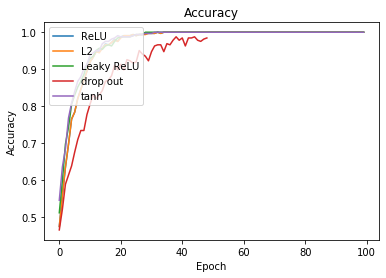

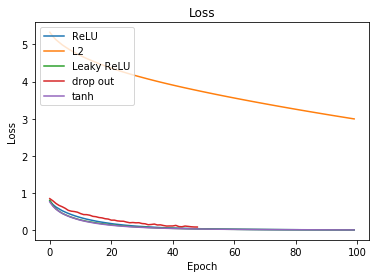

In [595]:
plt.plot(relu_res_history.history['accuracy'])
plt.plot(L2_res_history.history['accuracy'])
plt.plot(lr_res_history.history['accuracy'])
plt.plot(drop_res_history.history['accuracy'])
plt.plot(tanh_res_history.history['accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ReLU','L2', 'Leaky ReLU','drop out','tanh'], loc='upper left')
plt.show()

plt.plot(relu_res_history.history['loss'])
plt.plot(L2_res_history.history['loss'])
plt.plot(lr_res_history.history['loss'])
plt.plot(drop_res_history.history['loss'])
plt.plot(tanh_res_history.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ReLU','L2', 'Leaky ReLU','drop out','tanh'], loc='upper left')
plt.show()

# Error analysis

In [596]:
#return false positive, fasle negative, prediction lable(0,1) for test set   
def pred_and_error(model,X_test,Y_test,df_test):
    err_fp=[]
    err_fn=[]
    Y_test_pred=[]
    for i in range(len(X_test)):
        pred_result_gold= np.argmax(model.predict(X_test[i].reshape(1,-1)))
        Y_test_pred.append(pred_result_gold)
        if Y_test[i] != pred_result_gold:
            if Y_test[i] == 0:
                err_fn.append((df_test[i],i))
            else:
                err_fp.append((df_test[i],i))
    return err_fp,err_fn,Y_test_pred


In [603]:
#return top num errors of false positive and false negative individually  
def most_num_error(model_list,X_test,Y_test,df_test,num):
    fre_index_fp={}
    fre_index_fn={}
    fre_error_fp=[]
    fre_error_fn=[]
    for model in (model_list):
        err_fp,err_fn,Y_test_pred=pred_and_error(model,X_test,Y_test,df_test)
        for error in err_fp:
            if error[1] in fre_index_fp:
                fre_index_fp[error[1]]+=1
            else:
                fre_index_fp[error[1]]=1
        for error in err_fn:
            if error[1] in fre_index_fn:
                fre_index_fn[error[1]]+=1
            else:
                fre_index_fn[error[1]]=1
    sorted_fp=sorted(fre_index_fp.items(),key=operator.itemgetter(1),reverse=True)[:num]
    for i in range(len(sorted_fp)):
        fre_error_fp.append((df_doc_test[sorted_fp[i][0]],sorted_fp[i][1]))
    sorted_fn=sorted(fre_index_fn.items(),key=operator.itemgetter(1),reverse=True)[:num]
    for i in range(len(sorted_fp)):
        fre_error_fn.append((df_doc_test[sorted_fn[i][0]],sorted_fn[i][1]))
    
    return fre_error_fp,fre_error_fn
    
    


In [604]:
#preprocess single review  
def standarize_test(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_test = scaler.transform(X_test)
    return  X_test

def preprocess_test(df_train,df_error):
    
    vocabulary=get_vocabulary(df_train)
    
    X_train, Y_train = text2vec(df_train,vocabulary)
    
    X_error, Y_error = text2vec(df_error,vocabulary)
    
    X_error=standarize_test(X_train, X_error)
    
        
    return X_error

In [605]:
%matplotlib inline 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
def confusion_mx(Y_test_pred,Y_test):
    conf_mx=confusion_matrix(Y_test_pred,Y_test)
    sns.heatmap(conf_mx, annot=True)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    row_sums=conf_mx.sum(axis=1,keepdims=True) 
    norm_conf_mx=conf_mx/row_sums
    sns.heatmap( norm_conf_mx,annot=True)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('confusion matrix')
    plt.show()

In [602]:
def vocabulary_test(df_true_false,num):
    dict_word_freq={}  
    for i in range(0,len(df_true_false)):
      sentence_tokens=get_list_tokens(df_true_false[i])
      for word in sentence_tokens:
        if word in stopwords: 
          continue
        if word not in dict_word_freq: 
          dict_word_freq[word]=1
        else: 
          dict_word_freq[word]+=1

    sorted_list = sorted(dict_word_freq.items(), key=operator.itemgetter(1), reverse=True)[:num]
    vocabulary=[]
    for word,frequency in sorted_list:
      vocabulary.append(word)
    
    return vocabulary 

#return most frequently used words in true reviews and deceptive reviews
def unique_voca(ds_true,ds_false,num):
    unique_true_doc=[]
    unique_false_doc=[]
    voca_true_doc=vocabulary_test(ds_true,num)
    voca_false_doc=vocabulary_test(ds_false,num)
    for i in voca_true_doc:
        if i not in voca_false_doc:
            unique_true_doc.append(i)
    for i in voca_false_doc:
        if i not in voca_true_doc:
            unique_false_doc.append(i)
    return unique_true_doc,unique_false_doc
    

In [615]:
fre_error_fp,fre_error_fn=most_num_error([relu_res,L2_res,lr_res,tanh_res,drop_res],X_res_test,Y_res_test,df_res_test,4)
print("most 4-true but predict as false(0):\n")
for i in range(len(fre_error_fp)):
    print(fre_error_fp[i],end="\n\n")
print("most 4-Fasle but predict as true(1) :\n")
for i in range(len(fre_error_fn)):
    print(fre_error_fn[i],end="\n\n")


most 4-true but predict as false(0):

(["'This is a fantastic doctor!!!  I went to him b/c I had already had two capsular contractures since my previous breast augmentation.  He was very helpful, patient, and answered all of my questions.  I quickly scheduled my surgery, and I am beyond happy with the results.  I will definitely be using him again the future!!", 1], 5)

(['"I know you probably don\'t need to read another review about how amazing Doctor Forrest is but one feels the pressing need to tell the world about this surgeon. He is extraordinary. He is kind, patient, gentle and brilliant at what he does. If you get referred to Doctor Forrest count yourself a hundred thousand times lucky. He operated on my daughter for her craniosynistosis and did such a wonderful job. He goes above and beyond the call of duty and makes you feel you are taken care of and listened to. I think he is the finest doctor I have ever encountered. His staff obviously feel the same as every nurse and pract

In [616]:
df_error1=[["'This is a fantastic doctor!!!  I went to him b/c I had already had two capsular contractures since my previous breast augmentation.  He was very helpful, patient, and answered all of my questions.  \
I quickly scheduled my surgery, and I am beyond happy with the results.  \
I will definitely be using him again the future!!", 1]]

In [617]:
X_error1=preprocess_test(df_doc_train,df_error1)

In [618]:
np.set_printoptions(suppress=True)
model_list=[(relu_res,"relu_res"),(L2_res,"L2_res"),(lr_res,"lr_res"),(tanh_res,"tanh_res"),(drop_res,"drop_res")]
for i in model_list:
    print(i[1],i[0].predict(X_error2.reshape(1,-1)))

relu_res [[0.56588644 0.43411356]]
L2_res [[0.4893885 0.5106115]]
lr_res [[0.47576532 0.5242347 ]]
tanh_res [[0.47283974 0.5271602 ]]
drop_res [[0.5822308  0.41776922]]


In [686]:
err_fp,err_fn,Y_test_pred=pred_and_error(tanh_res,X_res_test,Y_res_test,df_res_test)

In [687]:
unique_true_res,unique_false_res=unique_voca(ds_res_true,ds_res_false,150)

In [689]:
np.array(unique_false_res)

array(['love', 'decided', 'favorite', 'weber', 'perfectly', 'family',
       'quality', 'signature', 'anyone', 'quartino', 'taste', 'looking',
       'sure', 'pig', 'highly', 'ditka', 'prime', 'never', 'absolutely',
       'new', 'feel', 'purple', 'arrived', 'full', 'something',
       'perfection', 'way', 'overall', 'selection', 'greeted', 'found',
       'last', 'clean', 'quickly', 'girl', 'loved', 'mike', 'fantastic',
       'tried', 'flavor', 'entree', 'started', 'find', 'decor', 'soon',
       'course', 'ca'], dtype='<U10')

In [690]:
np.array(unique_true_res)

array(['people', 'view', 'plate', 'side', 'two', 'day', 'served',
       'without', 'cake', 'tasty', 'took', 'small', 'around', 'ate',
       'large', 'hour', '2', 'burger', 'though', 'fun', 'pork',
       'different', 'lot', 'big', 'shared', 'see', 'potato', 'sauce',
       'share', 'top', 'pizza', 'item', 'year', 'know', 'enough',
       'attentive', 'rib', 'going', 'lobster', 'outstanding', 'busy',
       'enjoy', 'three', 'long', 'cheese', 'chicken', "'d"], dtype='<U11')

In [624]:
err_fp,err_fn,Y_test_pred=pred_and_error(tanh_res,X_res_test,Y_res_test,df_res_test)

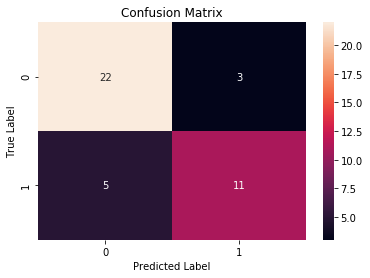

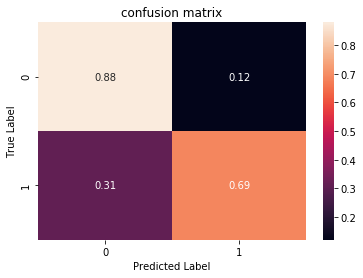

In [625]:
confusion_mx(Y_test_pred,Y_res_test)